<a href="https://colab.research.google.com/github/leoa4238/AI-Project/blob/main/template_515_Image_Segmentation_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경 설정
- GPU 사용 설정  
- 필요 라이브러리 설치

    1. `segmentation-models-pytorch` - **이미지 분할(Segmentation) 모델**을 제공하는 라이브러리
        - **주요 기능**  : ResNet, VGG, EfficientNet, Unet, FPN, PSPNet 등 사전 학습된 모델을 지원
        - **사용 예**: 의료 영상 분할, 자율 주행차의 도로 영역 탐지, 위성 이미지의 토지 분류 등

    2. `albumentations` -  **데이터 증강(Data Augmentation)**을 쉽게 수행할 수 있도록 설계된 라이브러리
        - **주요 기능**  :  **이미지 회전, 자르기, 확대, 밝기 조정, 노이즈 추가 등** 다양한 변환을 수행
        - **사용 예**: 이미지 분류, 객체 탐지, 이미지 분할 등의 데이터 증강을 통해 모델의 일반화 성능을 높이기 위해 사용

    3. `opencv-contrib-python` - **이미지 처리** 라이브러리
        - **주요 기능**  : 다양한 이미지/동영상 처리 함수 및 **엣지 검출, 필터링, 형태 변환, 객체 추적** 등 고급 이미지 처리 기능 제공  
        - **사용 예**: 객체 검출, 이미지 필터링, 동영상 분석, AR(Augmented Reality), 머신러닝 기반의 컴퓨터 비전 작업 등

In [1]:
# segmentation-models-pytorch(SMP) 라이브러리 설치
# PyTorch 기반으로 다양한 세그멘테이션 모델(U-Net, DeepLabV3 등)을 쉽게 사용할 수 있도록 도와줌
!pip install -q segmentation-models-pytorch

# albumentations 라이브러리 최신 버전 설치
# 이미지 증강(Augmentation) 및 전처리를 위한 강력한 라이브러리
!pip install -Uq git+https://github.com/albumentations-team/albumentations

# OpenCV 최신 버전 설치 (contrib 포함)
# OpenCV는 이미지 처리 및 영상 분석을 위한 라이브러리
# `opencv-contrib-python`은 추가적인 확장 기능(SIFT, SURF 등)이 포함된 버전
!pip install -Uq opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
  Installing build dependencies ... done
 

In [2]:
# Human-Segmentation-Dataset-master dataset 사용을 위해  저장소 복제
!git clone https://github.com/ironmanciti/Computer_Vision_Object_Detection.git

Cloning into 'Computer_Vision_Object_Detection'...
remote: Enumerating objects: 876, done.
remote: Total 876 (delta 0), reused 0 (delta 0), pack-reused 876 (from 2)
Receiving objects: 100% (876/876), 203.66 MiB | 39.13 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [3]:
import torch
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터셋 로드 및 시각화

In [4]:
# 학습 데이터셋 정보 (CSV 파일 경로)
CSV_FILE = '/content/Computer_Vision_Object_Detection/Human-Segmentation-Dataset-master/train.csv'

# 데이터가 저장된 기본 디렉터리
DATA_DIR = '/content/Computer_Vision_Object_Detection'

# 학습 설정값
EPOCHS = 25                      # 전체 학습 에포크 수
LEARNING_RATE = 0.003  # 학습률 (learning rate)
IMAGE_SIZE = 320           # 입력 이미지 크기 (320x320)

# 모델 백본(Backbone) 설정
#ENCODER = "timm-efficientnet-b0"  # EfficientNet 사용 시
ENCODER = "resnet18"           # ResNet-18을 백본으로 사용

# 사전 학습된 가중치 설정
WEIGHTS = "imagenet"           # ImageNet 데이터셋에서 사전 학습된 가중치 사용

# 학습 배치 크기 (Batch Size)
BATCH_SIZE = 16  # 한 번에 학습할 이미지 개수

# 학습에 사용할 디바이스 설정
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda:0


In [5]:
pd.set_option('display.max_colwidth', None)

#  이미지 경로와 마스크(정답) 경로를 불러옴.
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth/1.png,Human-Segmentation-Dataset-master/Training_Images/1.jpg
1,Human-Segmentation-Dataset-master/Ground_Truth/10.png,Human-Segmentation-Dataset-master/Training_Images/10.jpg
2,Human-Segmentation-Dataset-master/Ground_Truth/100.png,Human-Segmentation-Dataset-master/Training_Images/100.jpg
3,Human-Segmentation-Dataset-master/Ground_Truth/101.png,Human-Segmentation-Dataset-master/Training_Images/101.jpg
4,Human-Segmentation-Dataset-master/Ground_Truth/102.png,Human-Segmentation-Dataset-master/Training_Images/102.jpg


In [6]:
# 첫 번째 이미지와 마스크를 불러와 시각화.
row = df.iloc[0]

# 이미지 및 마스크 경로 설정
image_path = os.path.join(DATA_DIR, row.images)
mask_path = os.path.join(DATA_DIR, row.masks)

# 이미지 읽기 및 RGB로 변환
image = cv2.imread(image_path)  # 이미지 파일 읽기
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR을 RGB로 변환
print(image.shape)

# 마스크 읽기
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print(mask.shape)

(183, 276, 3)
(183, 276)


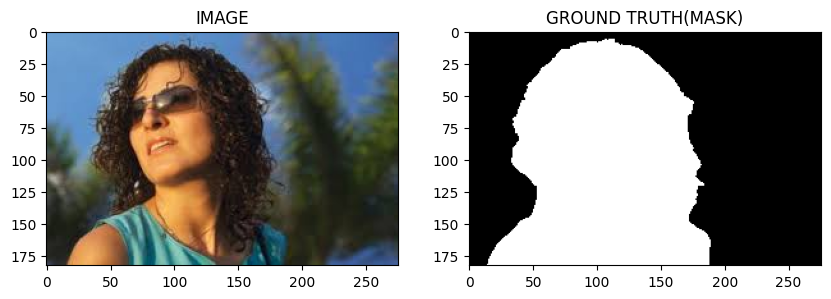

In [7]:
# 원본 이미지 & 객체 마스크(Ground Truth) 비교
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH(MASK)')
ax2.imshow(mask, cmap='gray')

In [8]:
# 학습용 데이터와 검증용 데이터로 분할
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)  # 데이터의 20%를 검증용으로 분리
train_df.shape, valid_df.shape

((232, 2), (58, 2))

### Data Augmentation (데이터 증강)

albumentation documentation : https://albumentations.ai/docs/

**albumentations**는 컴퓨터 비전(CV)에서 이미지 데이터 증강(Augmentation)을 수행하는 강력한 라이브러리입니다.
특히 **딥러닝 기반 객체 탐지(Object Detection), 세그멘테이션(Segmentation), 이미지 분류(Classification)**에서 널리 사용됩니다.

✅ 주요 특징  
✔ 빠른 속도 → OpenCV를 기반으로 구현되어, PyTorch와 TensorFlow 대비 매우 빠름  
✔ 강력한 변환 기능 → 기본적인 이미지 변환부터 고급 변환(Blur, Noise, Elastic Transform 등)까지 지원  
✔ 다양한 응용 가능 → 이미지 분류(Classification), 객체 탐지 (Detection), 세그멘테이션(Segmentation) 지원  

In [9]:
import albumentations as A

# 학습 데이터 증강 설정
train_augs = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),  # 이미지 크기를 IMAGE_SIZE x IMAGE_SIZE로 리사이즈
        A.HorizontalFlip(p=0.5),  # 50% 확률로 이미지 수평 뒤집기
        A.VerticalFlip(p=0.5)       # 50% 확률로 이미지 수직 뒤집기
    ])

# 검증 데이터 증강 설정
valid_augs = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE)  # 이미지 크기를 IMAGE_SIZE x IMAGE_SIZE로 리사이즈
    ])

### 사용자 정의 Dataset 생성

In [10]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df  # 데이터프레임 저장
        self.augmentations = augmentations  # 증강 기법 저장

    def __len__(self):
        return len(self.df)  # 데이터셋의 총 샘플 수 반환

    def __getitem__(self, idx):
        # 주어진 인덱스에 해당하는 데이터 가져오기
        row = self.df.iloc[idx]
        image_path = os.path.join(DATA_DIR, row.images)  # 이미지 경로 설정
        mask_path = os.path.join(DATA_DIR, row.masks)  # 마스크 경로 설정

        # 이미지 읽기 및 RGB로 변환
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 이미지 크기 가져오기
        desired_height, desired_width = image.shape[:2]

        # 마스크 읽기, 그레이스케일로 로드 후 리사이즈
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w)
        mask = cv2.resize(mask, (desired_width, desired_height))  # 이미지 크기에 맞춰 마스크 리사이즈
        mask = np.expand_dims(mask, axis=-1)            # 마스크에 채널 차원 추가 (h, w, 1)

        # 증강 적용
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # 이미지와 마스크의 차원 변환: (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # 이미지 및 마스크 정규화
        image = torch.tensor(image) / 255.0                   # 이미지 값을 0-1 범위로 정규화
        mask = torch.round(torch.tensor(mask) / 255.0)  # 마스크 값을 0 또는 1로 정규화 후 반올림

        return image, mask  # 이미지와 마스크 반환

In [11]:
# 학습용 및 검증용 데이터셋 생성
trainset = SegmentationDataset(train_df, train_augs)  # 학습 데이터셋 생성, 데이터 증강 포함
validset = SegmentationDataset(valid_df, valid_augs)  # 검증 데이터셋 생성, 검증 증강 포함

# 학습 데이터셋과 검증 데이터셋의 샘플 수 출력
len(trainset), len(validset)

(232, 58)

torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


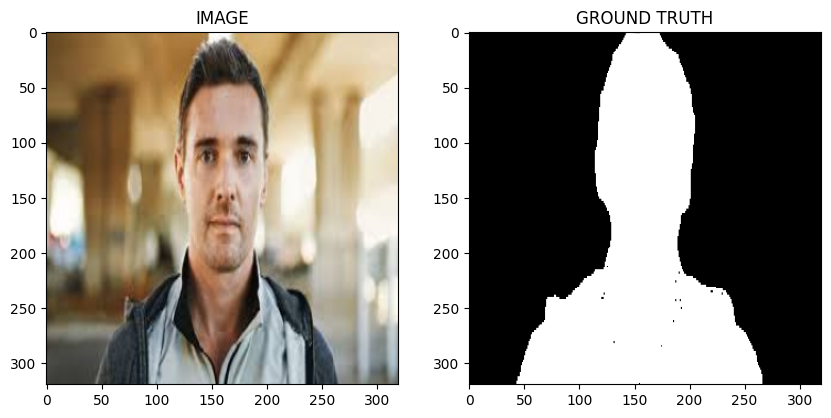

In [12]:
# 샘플 인덱스 설정
idx = 32

# 학습 데이터셋에서 인덱스에 해당하는 이미지와 마스크 가져오기
image, mask = trainset[idx]
print(image.shape, mask.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# 첫 번째 서브플롯에 이미지 출력
ax1.set_title('IMAGE')
ax1.imshow(image.permute(1, 2, 0))  # (c, h, w)를 (h, w, c)로 변환하여 이미지 표시

# 두 번째 서브플롯에 마스크(GROUND TRUTH) 출력
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1, 2, 0).squeeze(), cmap='gray')  # 마스크를 회색조(cmap='gray')로 표시

plt.show()

### 데이터 로더 작성

In [13]:
from torch.utils.data import DataLoader

# 학습용 데이터 로더 생성
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)  # 학습 데이터 로더, 배치 크기 설정 및 셔플 활성화

# 검증용 데이터 로더 생성
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE)  # 검증 데이터 로더, 배치 크기 설정

In [14]:
for image, mask in train_loader:
    print(image.shape)
    print(mask.shape)
    break

torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


### Segmentation Model 작성

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

**segmentation-models-pytorch (SMP)**는 PyTorch 기반의 이미지 분할(Segmentation) 모델 라이브러리입니다.

- 다양한 세그멘테이션(Segmentation) 모델을 쉽게 사용하고 학습할 수 있도록 제공하는 라이브러리입니다.  
- 사전 학습된 가중치(Pretrained Weights)를 활용하여 빠르게 Fine-Tuning할 수 있습니다.  
- 객체 탐지(Object Detection)와는 다르게, 픽셀 단위 분할을 수행하는 모델을 지원합니다.  

In [15]:
from torch import nn
import segmentation_models_pytorch as smp

# 분할 작업에 자주 사용되는 Dice 손실 함수 임포트
from segmentation_models_pytorch.losses import DiceLoss

**U-Net 모델 정의**
- smp.Unet() → 사전학습된 ResNet18을 백본(Backbone)으로 사용하는 U-Net 모델 생성  
- encoder 부분만 사전학습된 가중치 이용. decoder 부분은 무작위 초기화

In [17]:
# U-Net 모델 정의
class SegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Unet 아키텍처 초기화
        self.architecture = smp.Unet(
            encoder_name=ENCODER,     # 인코더 이름 설정
            encoder_weights=WEIGHTS,   # 사전 학습된 가중치 사용 ('imagenet')
            in_channels=3,                        # 입력 이미지 채널 수 (RGB이므로 3 채널)
            classes=1,                               # 출력 클래스 수 (이진 분할이므로 1 클래스)
            activation=None                      # 마지막 레이어에 활성화 함수 사용 안 함
        )

    def forward(self, images, masks=None):
        # 입력 이미지를 모델에 통과시켜 예측값(logits) 생성
        logits = self.architecture(images)

        # 마스크가 주어졌다면 (훈련 모드)
        if masks is not None:
            # Dice 손실 계산 : 분할 정확도를 높이기 위해 사용
            loss1 = DiceLoss(mode='binary')(logits, masks)
            # Binary Cross Entropy 손실 계산 : 이진 분류 문제 해결을 위해 사용
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            # 두 손실을 더해서 반환 (훈련 시 사용)
            return logits, loss1 + loss2

        # 마스크가 없을 때는 예측값만 반환 (추론 시 사용)
        return logits

In [18]:
model = SegmentationModel()
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

SegmentationModel(
  (architecture): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

### Train and Validation 함수 작성

In [19]:
def train_fn(data_loader, model, optimizer):
    model.train()        # 모델을 학습 모드로 설정
    total_loss = 0       # 총 손실 초기화

    # 데이터 로더에서 이미지와 마스크를 가져와 학습
    for images, masks in tqdm(data_loader):

        # 이미지를 지정한 장치(DEVICE)로 이동
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        # 옵티마이저의 그래디언트 초기화
        optimizer.zero_grad()
        # 모델에 이미지를 입력하여 예측값과 손실 계산
        logits, loss = model(images, masks)
        # 손실의 그래디언트를 계산하고 역전파
        loss.backward()
        # 옵티마이저를 통해 가중치 업데이트
        optimizer.step()

        # 현재 배치의 손실을 총 손실에 더하기
        total_loss += loss.item()

    # 평균 손실 반환
    return total_loss / len(data_loader)

In [20]:
def eval_fn(data_loader, model):
    model.eval()       # 모델을 평가 모드로 설정
    total_loss = 0     # 총 손실 초기화

    # 그래디언트 계산 비활성화
    with torch.inference_mode():
        # 데이터 로더에서 이미지와 마스크를 가져와 평가
        for images, masks in tqdm(data_loader):

            # 이미지를 지정한 장치(DEVICE)로 이동
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            # 모델에 이미지를 입력하여 예측값과 손실 계산
            logits, loss = model(images, masks)

            # 현재 배치의 손실을 총 손실에 더하기
            total_loss += loss.item()

    # 평균 손실 반환
    return total_loss / len(data_loader)

### Model Train

In [21]:
# Adam 옵티마이저 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # 학습률 설정

# 최적 검증 손실 초기값을 무한대로 설정
best_valid_loss = np.inf

# 학습을 EPOCHS만큼 반복
for i in range(EPOCHS):

    # 학습 데이터셋을 사용하여 모델 학습
    train_loss = train_fn(train_loader, model, optimizer)

    # 검증 데이터셋을 사용하여 모델 평가
    valid_loss = eval_fn(valid_loader, model)

    # 검증 손실이 이전 최적 손실보다 낮으면 모델 저장
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')     # 최적 모델 저장
        print("Better model saved...")
        best_valid_loss = valid_loss        # 최적 검증 손실 갱신

    # 현재 에포크의 학습 손실과 검증 손실 출력
    print(f"Epoch : {i+1} Train_Loss: {train_loss},  Valid_Loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Better model saved...
Epoch : 1 Train_Loss: 1.0564261595408122,  Valid_Loss: 2.706632971763611


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Better model saved...
Epoch : 2 Train_Loss: 0.8419462323188782,  Valid_Loss: 2.5837783813476562


100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


Better model saved...
Epoch : 3 Train_Loss: 0.7419333060582479,  Valid_Loss: 0.8061406314373016


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Better model saved...
Epoch : 4 Train_Loss: 0.6746090054512024,  Valid_Loss: 0.7012170851230621


100%|██████████| 4/4 [00:00<00:00,  6.56it/s]


Better model saved...
Epoch : 5 Train_Loss: 0.6031114260355631,  Valid_Loss: 0.684182733297348


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Epoch : 6 Train_Loss: 0.6031581978003184,  Valid_Loss: 0.7281640917062759


100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


Better model saved...
Epoch : 7 Train_Loss: 0.587131780385971,  Valid_Loss: 0.6283716708421707


100%|██████████| 4/4 [00:00<00:00,  6.69it/s]


Better model saved...
Epoch : 8 Train_Loss: 0.566218904654185,  Valid_Loss: 0.5300138369202614


100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


Epoch : 9 Train_Loss: 0.5378564516703288,  Valid_Loss: 0.6209853142499924


100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


Better model saved...
Epoch : 10 Train_Loss: 0.46294169227282206,  Valid_Loss: 0.4685600847005844


100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


Epoch : 11 Train_Loss: 0.4558962285518646,  Valid_Loss: 0.6521045118570328


100%|██████████| 4/4 [00:00<00:00,  6.52it/s]


Epoch : 12 Train_Loss: 0.4610575874646505,  Valid_Loss: 0.4970536008477211


100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


Epoch : 13 Train_Loss: 0.40392220417658486,  Valid_Loss: 0.6875731498003006


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Better model saved...
Epoch : 14 Train_Loss: 0.39708328048388164,  Valid_Loss: 0.43672773241996765


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


Epoch : 15 Train_Loss: 0.4130123833815257,  Valid_Loss: 0.4666939079761505


100%|██████████| 4/4 [00:00<00:00,  6.63it/s]


Epoch : 16 Train_Loss: 0.4536715586980184,  Valid_Loss: 0.4546787068247795


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch : 17 Train_Loss: 0.41170183817545575,  Valid_Loss: 0.4443602003157139


100%|██████████| 4/4 [00:00<00:00,  6.67it/s]


Epoch : 18 Train_Loss: 0.3901686946551005,  Valid_Loss: 0.44497598707675934


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


Epoch : 19 Train_Loss: 0.38606925010681153,  Valid_Loss: 0.5641122385859489


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Epoch : 20 Train_Loss: 0.3426620344320933,  Valid_Loss: 0.4889979511499405


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Better model saved...
Epoch : 21 Train_Loss: 0.31705821057160694,  Valid_Loss: 0.42482199519872665


100%|██████████| 4/4 [00:00<00:00,  6.51it/s]


Epoch : 22 Train_Loss: 0.3069598933060964,  Valid_Loss: 0.47736024856567383


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


Better model saved...
Epoch : 23 Train_Loss: 0.310593244433403,  Valid_Loss: 0.4017864912748337


100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


Better model saved...
Epoch : 24 Train_Loss: 0.29961552917957307,  Valid_Loss: 0.36551230400800705


100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

Epoch : 25 Train_Loss: 0.2928128600120544,  Valid_Loss: 0.5209317728877068


### Inference

In [22]:
len(validset)

58

In [23]:
idx = 2  # 예측할 검증 데이터셋의 인덱스 설정
idx = 50  # 예측할 검증 데이터셋의 인덱스 설정

# 저장된 최적 모델의 가중치 로드
model.load_state_dict(torch.load('/content/best_model.pt'))

# 검증 데이터셋에서 이미지와 마스크 가져오기
image, mask = validset[idx]
print(image.shape, mask.shape)

# 모델을 사용하여 예측 마스크 생성 (차원을 맞추기 위해 unsqueeze 사용)
logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) => (1, C, H, W)
print(logits_mask.shape)

# 예측값에 시그모이드 함수를 적용하여 확률 값으로 변환
pred_mask = torch.sigmoid(logits_mask)
print(pred_mask.shape)

# 0.5를 기준으로 이진화하여 최종 예측 마스크 생성
pred_mask = (pred_mask > 0.5) * 1.0  # 0.5보다 크면 1.0, 아니면 0.0
print(pred_mask.shape)

torch.Size([3, 320, 320]) torch.Size([1, 320, 320])
torch.Size([1, 1, 320, 320])
torch.Size([1, 1, 320, 320])
torch.Size([1, 1, 320, 320])


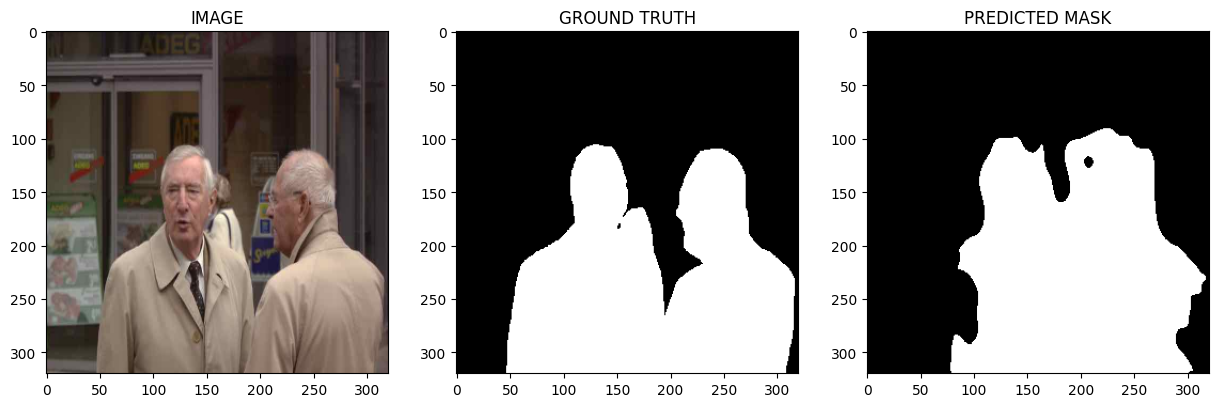

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 첫 번째 서브플롯에 원본 이미지 출력
ax1.set_title('IMAGE')
ax1.imshow(image.permute(1, 2, 0))  # (C, H, W)를 (H, W, C)로 변환하여 이미지 표시

# 두 번째 서브플롯에 실제 마스크(GROUND TRUTH) 출력
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1, 2, 0).squeeze(), cmap='gray')  # 마스크를 회색조로 표시

# 세 번째 서브플롯에 예측 마스크(PREDICTED MASK) 출력
ax3.set_title('PREDICTED MASK')
pred_mask = pred_mask.to("cpu").squeeze(0)  # 예측 마스크를 CPU로 이동하고 첫 번째 차원 제거
ax3.imshow(pred_mask.permute(1, 2, 0).squeeze(), cmap='gray')  # 예측 마스크를 회색조로 표시

plt.show()